In [ ]:
import sys
import os

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import torchvision.transforms as transforms

current_dir = os.getcwd()
src_dir = os.path.join(current_dir, '..')

if src_dir not in sys.path:
    sys.path.append(src_dir)

from src.data.classification import TumorBinaryClassificationDataset
from src.enums import DataSplit

In [9]:
DATASETS_ROOT = os.path.join(current_dir, '..', 'datasets')
BATCH_SIZE = 4

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor(),  # Convert images to tensor
    # Add any other transforms here, e.g., normalization
])

dataset = TumorBinaryClassificationDataset(root_dir=DATASETS_ROOT, split=DataSplit.TRAIN, transform=transform)

data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

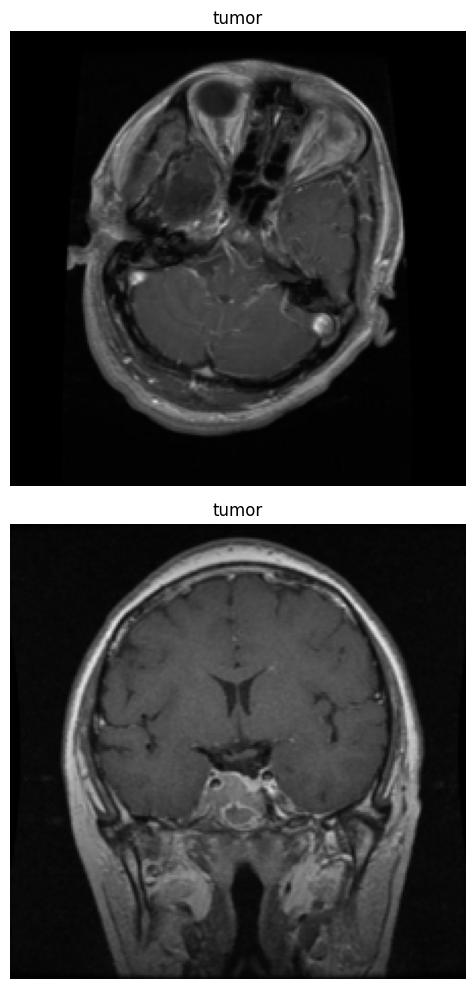

In [10]:
def show_images_with_labels(images, labels, nmax=32):
    # Convert a batch of images and labels into a grid of images with labels underneath
    n_rows = (nmax + 1) // 2  # Add 1 to nmax to ensure rounding up if nmax is odd
    n_cols = 1  # Two images per row
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 5))
    axs = axs.flatten()
    
    for ax, image, label in zip(axs, images, labels):
        
        ax.imshow(image.permute(1, 2, 0))  # Convert from PyTorch's CxHxW to Matplotlib's HxWxC
        ax.set_title(label)
        ax.axis('off')
        

    # Hide any remaining subplots not used
    for ax in axs[len(images):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

images, labels = next(iter(data_loader))

transformed_labels = [dataset.idx_to_class[label.item()] for label in labels]
show_images_with_labels(images, transformed_labels, nmax=BATCH_SIZE) 

In [13]:
DATASETS_ROOT = os.path.join(current_dir, '..', 'datasets')
BATCH_SIZE = 10

def show_images_as_arrays(images, labels):    
    
    for image, label in zip(images, labels):
        print(image.shape)
        print(label)
        print(image)


images, labels = next(iter(data_loader))

transformed_labels = [dataset.idx_to_class[label.item()] for label in labels]
show_images_as_arrays(images, transformed_labels) 

torch.Size([3, 224, 224])
notumor
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
torch.Size([3, 224, 224])
tumor
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models


# Step 1: Prepare the Data
train_dataset = TumorBinaryClassificationDataset(root_dir=DATASETS_ROOT, split=DataSplit.TRAIN, transform=transform)
test_dataset = TumorBinaryClassificationDataset(root_dir=DATASETS_ROOT, split=DataSplit.TEST, transform=transform)


# Define data loaders for training and testing sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Step 2: Define the Model
# Use a pre-trained model as the backbone and add a few additional layers for classification
class TumorBinaryClassifier(nn.Module):
    def __init__(self):
        super(TumorBinaryClassifier, self).__init__()
        self.model = models.resnet18(pretrained=True)  # Load a pre-trained ResNet18 model
        self.model.fc = nn.Linear(512, 2)             # Replace the last fully connected layer for binary classification

    def forward(self, x):
        return self.model(x)

# Step 3: Define the Loss Function and Optimizer
model = TumorBinaryClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 4: Training Loop
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Step 5: Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on the test set: {accuracy:.2f}%')


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/jackkrolik/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:992)>

In [ ]:
def save_model(model, save_path):
    torch.save(model.state_dict(), save_path)

save_path = '../model_registry/tumor_binaryclassifier.pth'
save_model(model, save_path)

In [ ]:
test_model = TumorBinaryClassifier()
test_model.load_state_dict(torch.load(save_path))

In [ ]:
# Step 5: Evaluation
test_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = test_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on the test set: {accuracy:.2f}%')